In [31]:
from contextlib import closing
import io
import numpy
from copy import deepcopy

from matplotlib import pyplot
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    concatenate,
    Input,
    InputLayer,
    MaxPooling2D,
)
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist


In [33]:
# ---------- Prepare data section ---------- #
# load mnist dataset
# x_train, y_train - training dataset and validation vector
# x_test, y_test - validation dataset and validation vector
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# make a deep copy to render data
render_x = deepcopy(x_train)
render_y = deepcopy(y_train)

# declare num of training samples
num_labels = len(numpy.unique(y_train))

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

# convert a single list to categorical list of lists
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

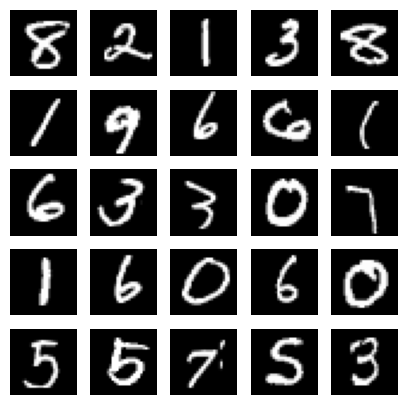

In [34]:
# ----------- Show sample section ---------- #
indexes = numpy.random.randint(0, render_x.shape[0], size=25)
images = render_x[indexes]
labels = render_y[indexes]
# plot the 25 mnist digits
pyplot.figure(figsize=(5,5))
for i in range(len(indexes)):
    pyplot.subplot(5, 5, i + 1)
    image = images[i]
    pyplot.imshow(image, cmap='gray')
    pyplot.axis('off')
pyplot.savefig('samples.png')
pyplot.show()
pyplot.close('all')

In [ ]:
# network parameters
BATCH_SIZE = 64
HIDDEN_UNITS = 128
DROPOUT = 0.2
KERNEL_SIZE = 3 
POOL_SIZE = 2
FILTERS = 64
EPOCHS = 20
input_shape = (image_size, image_size, 1)

def build_model(units=HIDDEN_UNITS, dropout=DROPOUT, input_size=input_size,
                num_labels=num_labels, kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE,
                filters=FILTERS):

    # left branch of Y network
    left_inputs = Input(shape=input_shape)
    stack_left = left_inputs
    n_filters = filters
    # 3 layers of Conv2D-Dropout-MaxPooling2D
    # number of filters doubles after each layer (32-64-128)
    for i in range(2):
        stack_left = Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', activation='relu')(stack_left)
        stack_left = Dropout(dropout)(stack_left)
        stack_left = MaxPooling2D()(stack_left)
        n_filters *= 2

    # right branch of Y network
    right_inputs = Input(shape=input_shape)
    stack_right = right_inputs
    n_filters = filters
    # 3 layers of Conv2D-Dropout-MaxPooling2Do
    # number of filters doubles after each layer (32-64-128)
    for i in range(2):
        stack_right = Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', activation='relu', dilation_rate=2)(stack_right)
        stack_right = Dropout(dropout)(stack_right)
        stack_right = MaxPooling2D()(stack_right)
        n_filters *= 2
        n_filters *= 2

    # merge left and right branches outputs
    stack = concatenate([stack_left, stack_right])
    # feature maps to vector before connecting to Dense
    stack = Flatten()(stack)
    stack = Dropout(dropout)(stack)
    outputs = Dense(num_labels, activation='softmax')(stack)
    model = Model([left_inputs, right_inputs], outputs)
    return model

model = build_model()
plot_model(model, to_file='architecture.png', show_shapes=True, show_layer_names=True)

# close file handler at the end of context execution
with closing(io.StringIO()) as fh:
    model.summary(print_fn=lambda x: fh.write(x + "\n"))
    summary_str = fh.getvalue()

# set up image representation
pyplot.figure(figsize=(12, 6))
pyplot.text(0, 1, summary_str, fontsize=12, family='monospace', va='top')
pyplot.axis('off')
# save as PNG
pyplot.savefig('model-summary.png', bbox_inches='tight')
pyplot.close()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
# model = load_model('model.keras')

In [7]:
# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([x_train, x_train], y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
# validate the model on test dataset to determine generalization
_, acc = model.evaluate([x_test, x_test], y_test, batch_size=BATCH_SIZE, verbose=0)
model.save('model.keras')

Epoch 1/20


2025-01-05 10:54:02.274487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-05 10:54:02.392039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-01-05 10:54:02.726486: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7cedb247d2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-05 10:54:02.726525: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-01-05 10:54:02.732297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-05 10:54:02.852134: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

938/938 [==============================] - 12s 10ms/step - loss: 0.8222 - accuracy: 0.9411
Epoch 2/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0827 - accuracy: 0.9759
Epoch 3/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0704 - accuracy: 0.9798
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0620 - accuracy: 0.9818
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0633 - accuracy: 0.9820
Epoch 6/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0563 - accuracy: 0.9839
Epoch 7/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0621 - accuracy: 0.9833
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0537 - accuracy: 0.9852
Epoch 9/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0543 - accuracy: 0.9859
Epoch 10/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0537 - accuracy: 0.986

2025-01-05 10:57:12.365930: W tensorflow/core/grappler/utils/graph_view.cc:836] No registered 'SpaceToBatchND' OpKernel for GPU devices compatible with node {{node model/conv2d_2/Conv2D/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_uint8_SpaceToBatchND}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_UINT8, Tblock_shape=DT_INT32, Tpaddings=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"
	.  Registered:  device='XLA_CPU_JIT'; Tpaddings in [DT_INT32, DT_INT64]; Tblock_shape in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, DT_INT8, DT_COMPLEX64, DT_INT64, DT_BOOL, DT_QINT8, DT_QUINT8, DT_QINT32, DT_BFLOAT16, DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64, DT_FLOAT8_E5M2, DT_FLOAT8_E4M3FN]
  device='XLA_GPU_JIT'; Tpaddings in [DT_INT32, DT_INT64]; Tblock_shape in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, DT_INT8, DT_COMPLEX64, DT_INT64, DT_BOOL, DT_QINT8, 

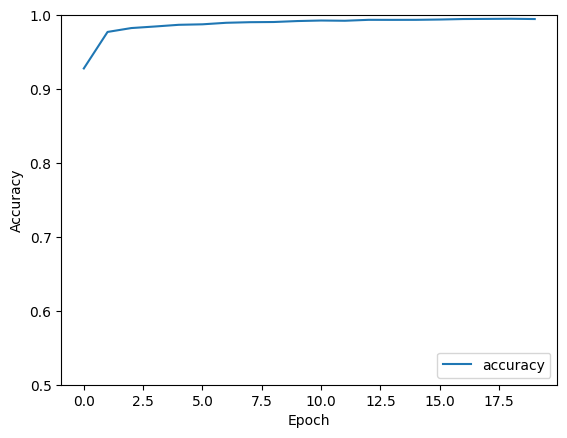

313/313 - 1s - 4ms/step - accuracy: 0.9905 - loss: 0.0576
Final model accuracy: 99.050%


NameError: name 'pyplot' is not defined

: 

In [7]:
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.5, 1])
pyplot.legend(loc='lower right')
pyplot.savefig("accuracy-history.png")
pyplot.show()
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Final model accuracy: {test_acc*100:.3f}%", )